## Kernel Galerkin

This notebook is for playing around with the kernel galerkin method, trying it out for a specific case and visualization

In [1]:
import sys
import os

project_root = os.path.abspath("..")  # If notebooks is one folder above src
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import numpy as np
import pandas as pd
import ipywidgets as widgets
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm
from src.eigensolver.galerkin.galerkin_eigensolver import GalerkinSolver
from src.energy.quadratic import QuadraticEnergy
from src.energy.gaussian_mixture import GaussianMixture
from src.eigensolver.galerkin.kernel_basis import KernelBasis
from src.eigensolver.galerkin.constant_basis import ConstantBasis
from src.eigensolver.galerkin.orthogonal_basis import OrthogonalBasis
from src.eigensolver.galerkin.kernels.gaussian_kernel import GaussianKernel
from src.eigensolver.galerkin.kernels.polynomial_kernel import PolynomialKernel
from src.metrics.eigen_evaluator import EigenEvaluator
from src.metrics.pde_evaluator import ExactPDEEvaluator
from src.metrics.reconstruction_evaluator import ReconstructionEvaluator

from src.pdesolver.exact_solver import ExactEigenSolver
from src.pdesolver.fitted_solver import FittedEigenSolver

In [3]:
def kernel_experiment(experiment_params, energy, kernel_class = GaussianKernel):
    kernel_params = experiment_params['kernel_params']
    solver_params = experiment_params['solver_params']

    np.random.seed(42)
    dim = kernel_params['dim']
    x = energy.exact_sample((200000,))

    kernel = kernel_class(kernel_params)

    p = kernel_params['p']
    L_reg = solver_params['L_reg']
    k = solver_params['k']
    
    basis_points = energy.exact_sample((p,))
    basis = KernelBasis(kernel, basis_points)
    basis = ConstantBasis(basis)

    solver = GalerkinSolver(energy, x, solver_params)

    solver = solver.fit(basis,k=min(p-1,k),L_reg=L_reg)

    return x, solver

### 1D Experiment

In [4]:
metrics = ['eigen_error',
           'orth_error',
           'eigen_cost', 
           'eigenvalue_mse',
           'eigenfunc_mse', 
           "fitted_eigenvalue_mse"]

experiment_params = {
    'kernel_params': {
        'dim': 1,
        'p': 100,
        'scale': 5.0,
        'order': 3
    },
    'solver_params': {
        'regularizer': 0.0,
        'L_reg': 1e-6,
        'verbose': False,
        'k': 5
    }
}

energy = QuadraticEnergy(np.eye(experiment_params['kernel_params']['dim']))

x, solver = kernel_experiment(experiment_params, energy, GaussianKernel)

if solver is None:
    print('Error')
else:
    evaluator = EigenEvaluator(energy)
    x_eval = energy.exact_sample((10000,))

    out = evaluator.evaluate_metrics(solver, x_eval, metrics, k = experiment_params['solver_params']['k'])
    for metric in metrics:
        print(f'{metric}: {out[metric]}')

eigen_error: [1.55222571e-07 3.61001207e-03 1.00515481e-02 9.70130681e+00
 2.45076822e+01]
orth_error: [1.29923020e-11 3.23268029e-04 1.14944624e-03 3.62214473e-03
 4.45163235e-03]
eigen_cost: [3.55664633e-08 1.01205125e+00 3.12399220e+00 6.44499824e+00
 1.04637841e+01]
eigenvalue_mse: [7.64870855e-13 7.53345986e-05 4.36668361e-03 8.13597579e+00
 2.16580073e+01]
eigenfunc_mse: [1.02074982e-08 9.06631430e-04 1.38592524e-03 7.36210819e-03
 7.77494184e-03]
fitted_eigenvalue_mse: [2.26538718e-11 6.46528439e-08 2.01577425e-06 9.81672453e-06
 1.73536830e-05]


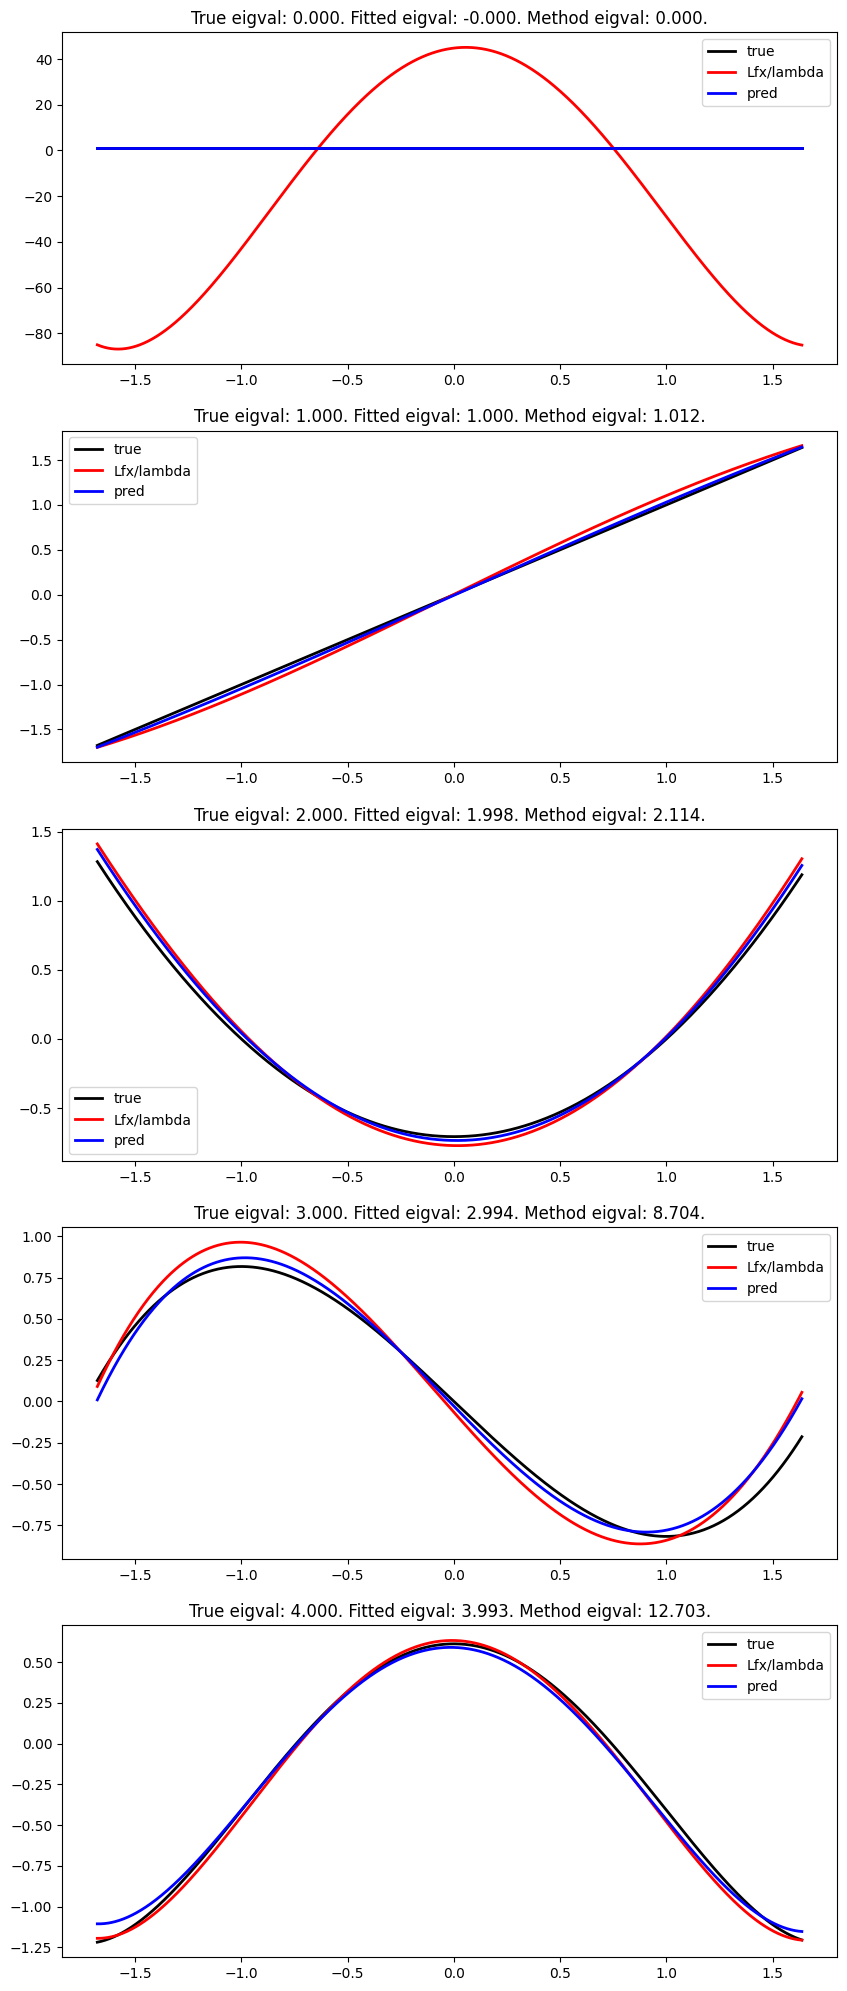

In [5]:
_ = evaluator.plot(solver,x_eval,5,plot_exact=True, plot_Lf = True)

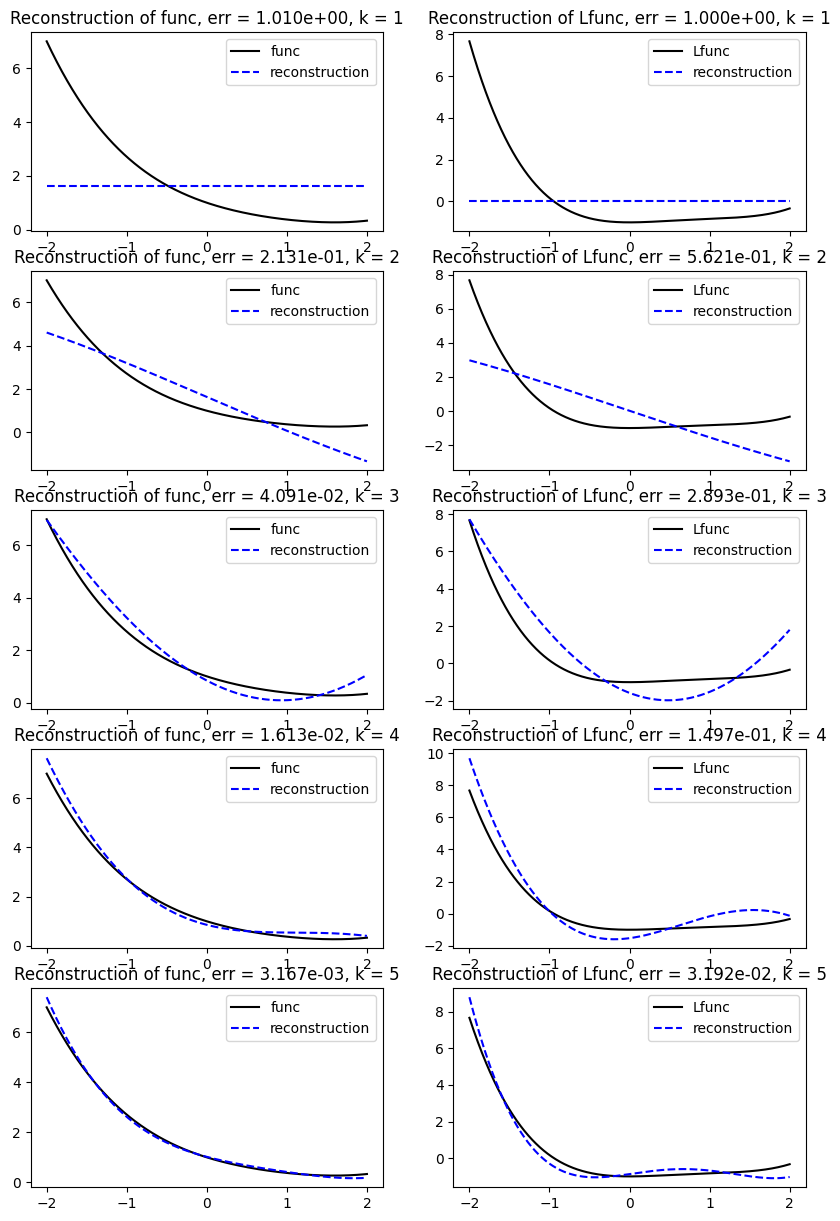

In [6]:
def func(x):
    return (1-x+x**2/2-x**3/6+x**4/24).sum()

reconstruction_evaluator = ReconstructionEvaluator(energy, func)

t = np.linspace(-2,2,1000)[:,None]

_ = reconstruction_evaluator.plot_reconstruction(t, solver.predict(t),
                                             x, solver.predict(x),
                                             solver.fitted_eigvals)

In [7]:
samples = energy.exact_sample((100000,))

fitted_solver = FittedEigenSolver(energy, samples, solver)
inner_prods = np.array([0,0,0,1])

def func(x_batch):
    return inner_prods@(energy.exact_eigfunctions(x_batch,len(inner_prods))).T

def exact_sol_func(x_batch, t):
    return np.sum(inner_prods[:,None,None] *
                np.exp(-energy.exact_eigvals(len(inner_prods))[:,None,None]*t[None,None,:]) * 
                (energy.exact_eigfunctions(x,len(inner_prods)).T)[:,:,None],axis=0)

T = 2000
t_max = 1
t = np.linspace(0,t_max,T)
x = np.linspace(-2,2,1000)[:,None]
k = 5

fitted_sol = fitted_solver.solve(func, t, x, k)
exact_sol = exact_sol_func(x, t)

pde_evaluator = ExactPDEEvaluator(energy, fitted_solver)

In [ ]:
a = {'a': 1, 'b': 4}
for i, key,value  in enumerate(a):
    print(i)
    print(key)

ValueError: not enough values to unpack (expected 3, got 2)

In [9]:
def plot_sol(time,k):
    i = int(time/t_max*T)
    plt.plot(x, exact_sol[:,i],label='exact solution',color='red')
    plt.plot(x, fitted_sol[k-1,:,i],label='fitted solution',color='blue')

    plt.plot(x, func(x),label='intial value',color='black',ls='--')
    plt.ylim(-3,5)
    plt.legend()

widgets.interact(plot_sol, time = widgets.FloatSlider(min=0,max=t_max-t_max/T,step=t_max/T), k = np.arange(1,k+1))

interactive(children=(FloatSlider(value=0.0, description='time', max=0.9995, step=0.0005), Dropdown(descriptio…

<function __main__.plot_sol(time, k)>

In [13]:
t = np.array([0,0.5,1,1.5,2])

pde_evaluator.compute_pde_error(inner_prods, x, t)

array([[ 1.00001361,  1.00027253,  1.00547033,  1.10985836,  3.20650036],
       [ 0.93147709,  0.83855203,  0.74711341,  1.74400604, 14.77788424],
       [ 0.93457373,  0.84621623,  0.76891307,  1.82230253, 15.1562327 ],
       [ 0.04048161,  0.04212671,  0.21053285,  1.92869106, 17.0380244 ],
       [ 0.05781938,  0.04566127,  0.20561588,  1.9150585 , 17.00844906],
       [ 0.05321385,  0.04410511,  0.20621287,  1.91596427, 17.00939437]])

In [52]:
np.mean( np.mean((fitted_sol - exact_sol[None,:,:])**2,axis=1) / np.var(exact_sol, axis=0)[None,:], axis = 1)


array([1.00077635, 0.83429938, 0.83619114, 0.07434967, 0.0691347 ])

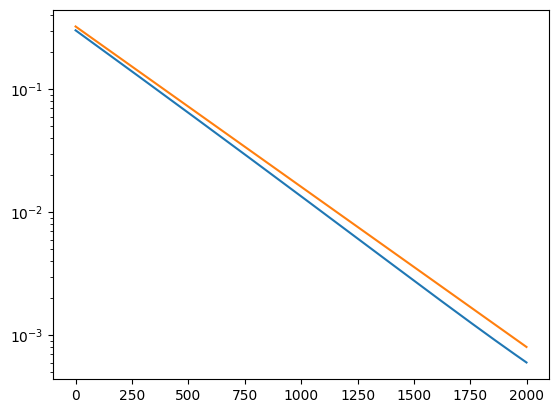

In [53]:
k_fit = 1
plt.plot((np.mean((fitted_sol - exact_sol[None,:,:])**2,axis=1))[k_fit])
plt.plot(np.var(exact_sol,axis=0))
#plt.plot((np.mean((fitted_sol - exact_sol[None,:,:])**2,axis=1) / np.var(exact_sol, axis=0)[None,:])[k_fit])
plt.yscale('log')

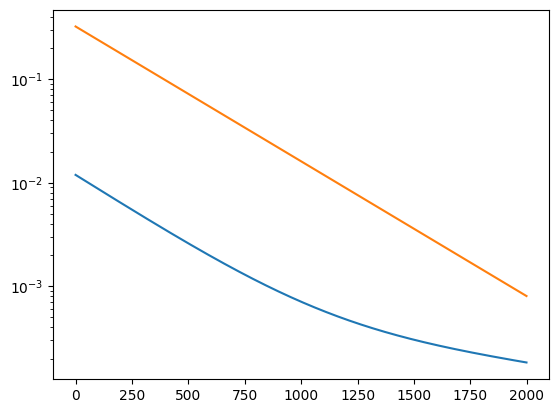

In [54]:
k_fit = 4
plt.plot((np.mean((fitted_sol - exact_sol[None,:,:])**2,axis=1))[k_fit])
plt.plot(np.var(exact_sol,axis=0))
#plt.plot((np.mean((fitted_sol - exact_sol[None,:,:])**2,axis=1) / np.mean(exact_sol**2, axis=0)[None,:])[k_fit])
plt.yscale('log')

### 2D Experiment

In [19]:
metrics = ['eigen_error','orth_error','eigen_cost', 'eigenvalue_mse','eigenfunc_mse', "fitted_eigenvalue_mse"]
experiment_params = {
    'kernel_params': {
        'dim': 2,
        'p': 100,
        'scale': 5.0,
        'order': 3
    },
    'solver_params': {
        'regularizer': 0.0,
        'L_reg': 1e-6,
        'verbose': False,
        'k': 6
    }
}

energy = QuadraticEnergy(np.eye(experiment_params['kernel_params']['dim']))

x, solver = kernel_experiment(experiment_params, energy, GaussianKernel)

if solver is None:
    print('Error')
else:
    evaluator = EigenEvaluator(energy)
    x_eval = energy.exact_sample((10000,))

    out = evaluator.evaluate_metrics(solver, x_eval, metrics, k = experiment_params['solver_params']['k'])
    for metric in metrics:
        print(f'{metric}: {out[metric]}')

eigen_error: [7.49093514e-08 3.97003456e-03 4.49729793e-03 1.04690787e-02
 1.48195041e-02 1.63578892e-02]
orth_error: [1.35258653e-11 1.81731479e-04 1.44913221e-04 8.43650467e-04
 7.09813922e-04 6.54674061e-04]
eigen_cost: [1.84418927e-08 9.70453394e-01 1.95879919e+00 3.78812140e+00
 5.66619827e+00 7.58204152e+00]
eigenvalue_mse: [9.19815467e-13 3.79363623e-04 2.82704365e-04 6.62840822e-03
 7.81930313e-03 7.47627589e-03]
eigenfunc_mse: [5.19175450e-09 1.31306980e-03 1.48653306e-03 2.21970158e-03
 3.54746111e-03 3.86246987e-03]
fitted_eigenvalue_mse: [8.93866422e-14 1.09079370e-05 8.52410487e-06 9.72321394e-06
 2.43150642e-05 2.80404298e-05]


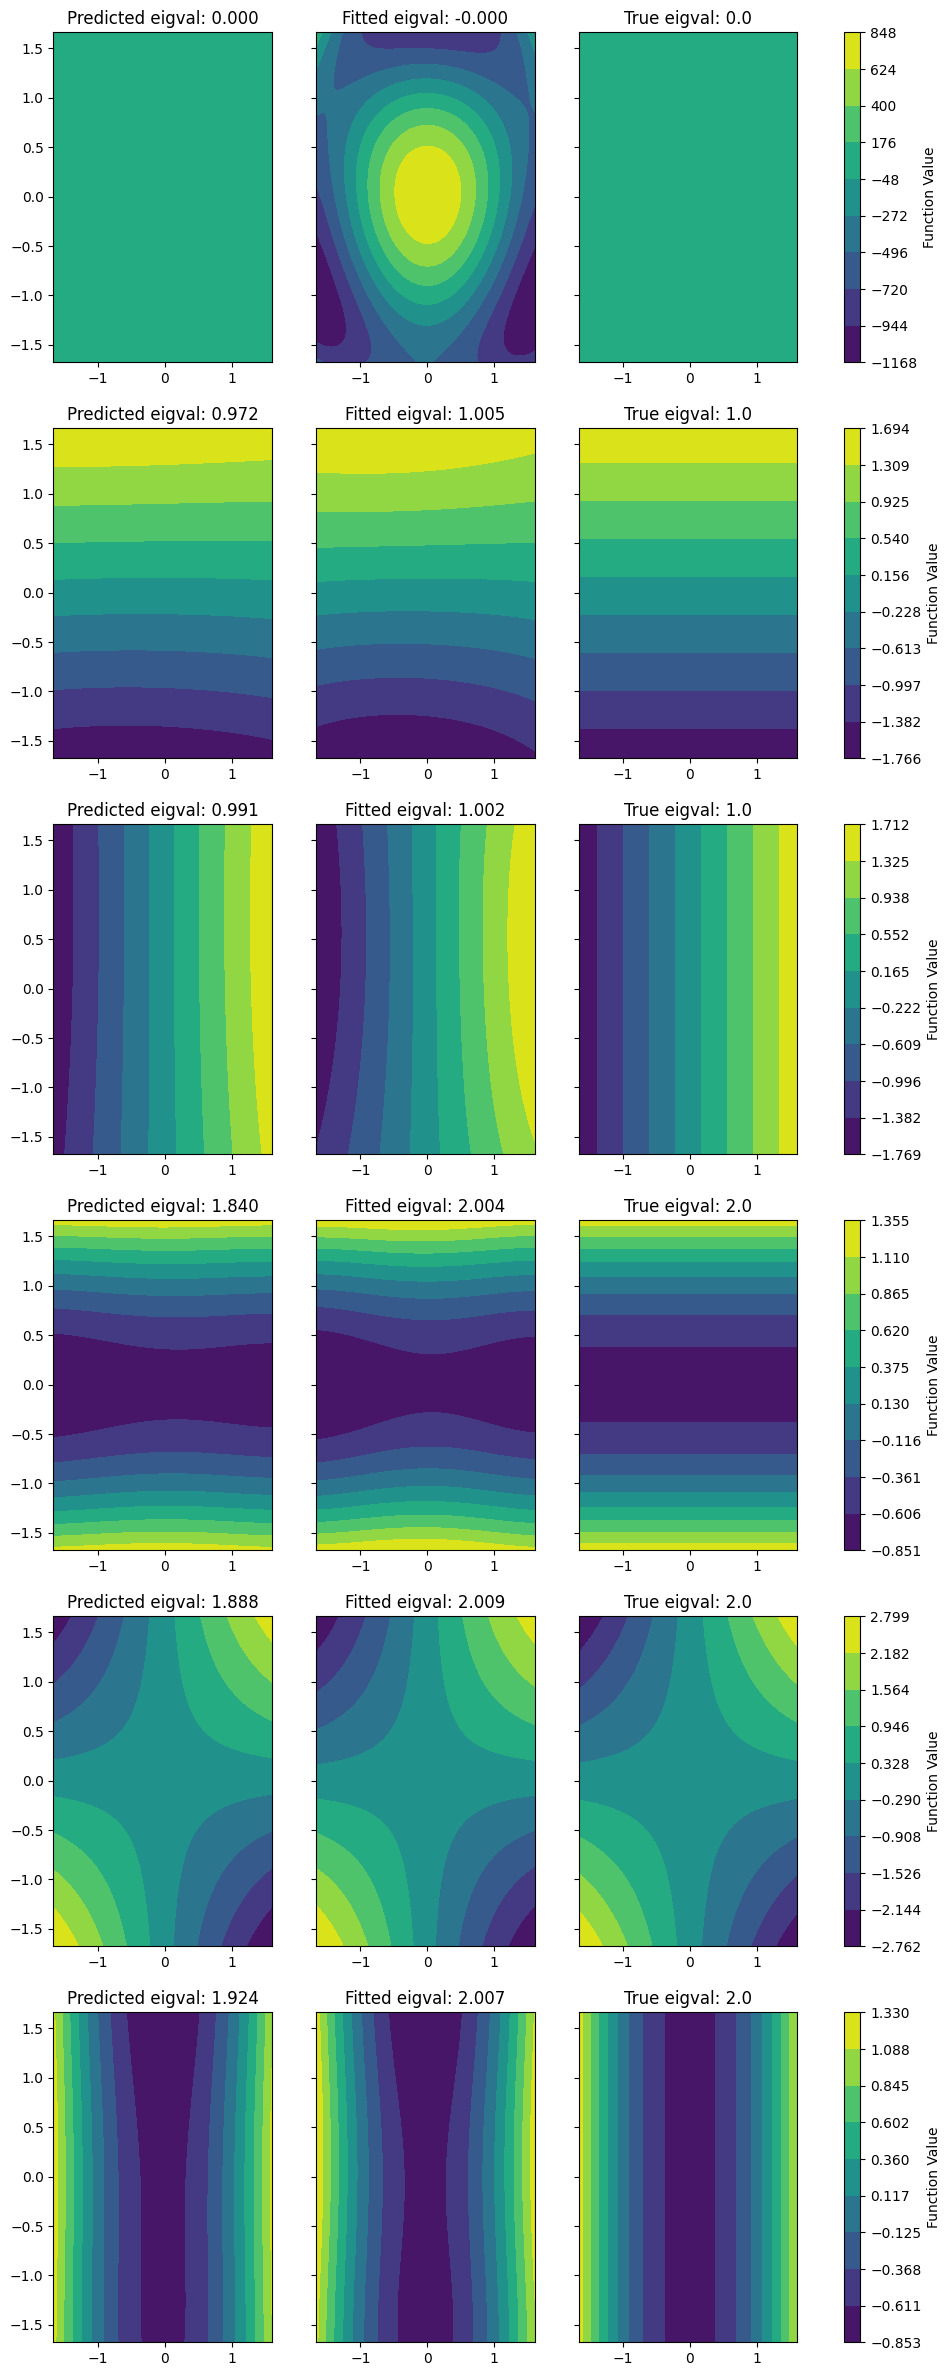

In [20]:
_ = evaluator.plot(solver,x_eval,6,plot_Lf=True,plot_exact=True)

## Gaussian Mixture

In [21]:
metrics = ['eigen_error','orth_error','eigen_cost', 'fitted_eigen_error']

dim = 2

experiment_params = {
    'kernel_params': {
        'dim': dim,
        'p': 300,
        'scale': 10.0,
        'order': 3
    },
    'solver_params': {
        'regularizer': 0.0,
        'L_reg': 1e-6,
        'verbose': False,
        'k': 200
    }
}

#means = np.array([np.zeros(dim),np.zeros(dim)])
#covs = np.array([np.diag(0.5+np.random.random(dim)),np.diag(0.5+np.random.random(dim))])

means = np.array([[0,0],[0,0]])
covs = np.array([[[5,0],[0,1]], [[1,0],[0,5]]])

#means = np.array([[0], [5]])
#covs = np.array([[[1]], [[1]]])
w = np.array([0.5,0.5])

energy = GaussianMixture(w,means,covs)
x, solver = kernel_experiment(experiment_params, energy, GaussianKernel)

if solver is None:
    print('Error')
else:
    evaluator = EigenEvaluator(energy)
    x_eval = energy.exact_sample((10000,))

    out = evaluator.evaluate_metrics(solver, x_eval, metrics, k = experiment_params['solver_params']['k'])
    for metric in metrics:
        print(f'{metric}: {out[metric]}')

eigen_error: [5.88136778e-08 1.36129222e-02 1.93353808e-02 2.04549696e-02
 2.55177458e-02 2.24941249e-02 6.12769395e-02 2.07245051e-01
 6.26848427e-01 7.93727292e+00 5.37261881e+01 2.86007655e+04
 6.99821015e+05 1.16547355e+07 3.07345912e+07 6.76155887e+09
 5.12473351e+10 3.28820478e+11 5.21378027e+11 7.17840896e+11
 6.83985049e+11 6.66487546e+11 6.42088400e+11 6.16473095e+11
 5.95099009e+11 5.73651820e+11 5.55565328e+11 5.37423693e+11
 5.20832919e+11 5.04929464e+11 4.89309915e+11 4.74179935e+11
 4.61832645e+11 4.49494868e+11 4.36909537e+11 4.25152653e+11
 4.15082019e+11 4.04458198e+11 3.94696051e+11 3.90833841e+11
 3.82972328e+11 3.77259480e+11 3.69447612e+11 3.62189992e+11
 3.56565397e+11 3.50718977e+11 3.43880607e+11 3.36923525e+11
 3.30354016e+11 3.24392959e+11 3.18865021e+11 3.14492466e+11
 3.10010285e+11 3.05477548e+11 3.02159621e+11 2.97204803e+11
 2.92773146e+11 2.89311465e+11 2.85322281e+11 2.80969473e+11
 2.76990339e+11 2.72867772e+11 2.69766290e+11 2.66340007e+11
 2.62896633

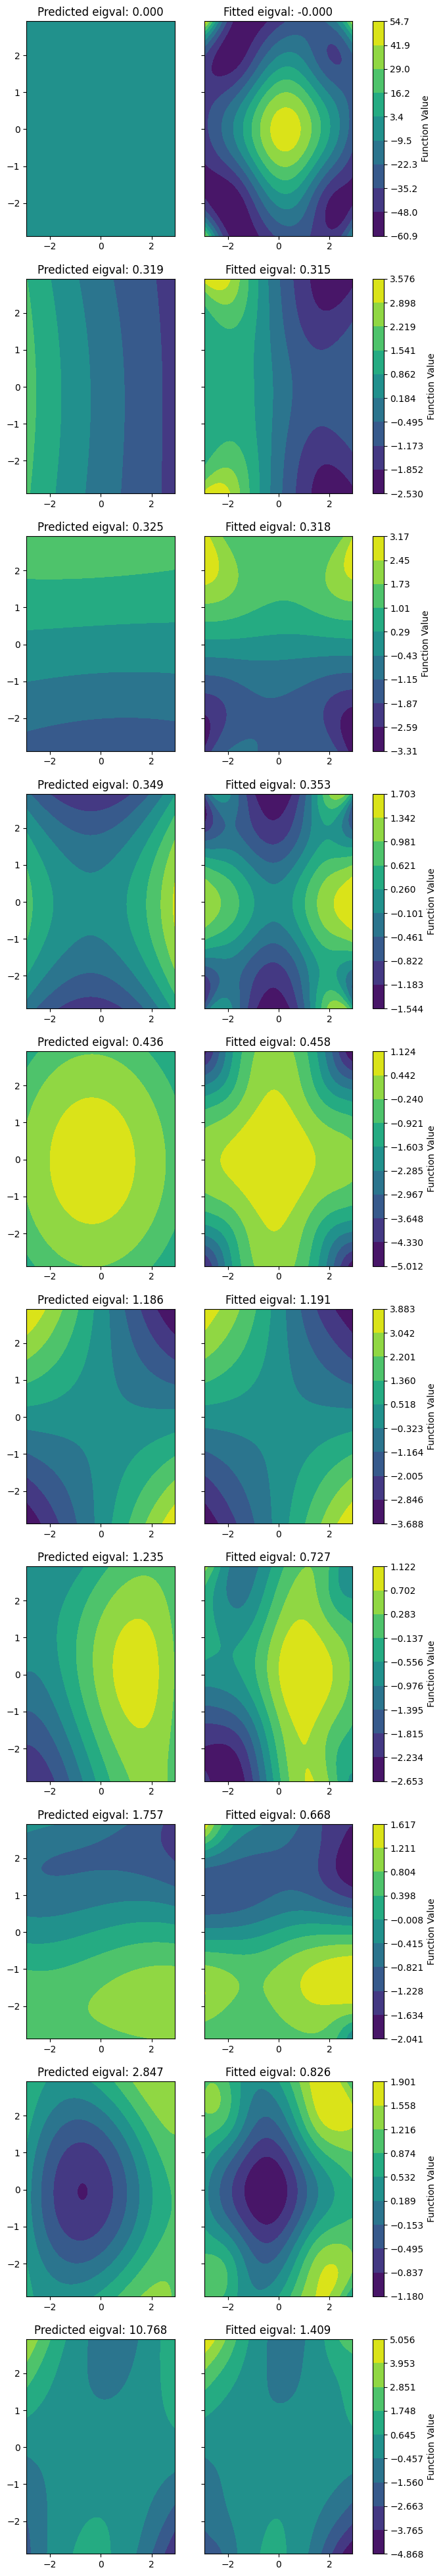

In [22]:
_ = evaluator.plot(solver,x_eval,10,plot_Lf=True)

## PDE

In [60]:
def plot_sol(time):
    i = int(time/t_max*T)
    plt.plot(x, sol[:,i],label='exact solution',color='red')
    plt.plot(x, fitted_sol[:,i],label='fitted solution',color='blue')

    plt.plot(x, func(x),label='intial value',color='black',ls='--')
    #plt.ylim(-3,5)
    plt.legend()

widgets.interact(plot_sol, time = widgets.FloatSlider(min=0,max=t_max-t_max/T,step=t_max/T))

interactive(children=(FloatSlider(value=0.0, description='time', max=4.995, step=0.005), Output()), _dom_class…

<function __main__.plot_sol(time)>

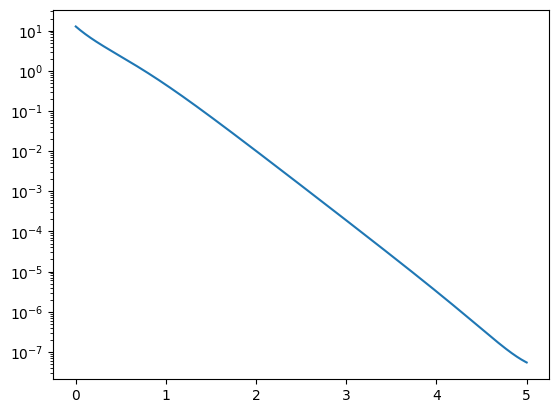

In [61]:
plt.plot(t,np.mean((sol - fitted_sol)**2,axis=0)/np.mean(sol**2,axis=0))
plt.yscale('log')

In [59]:
from scipy.special import eval_hermitenorm

In [64]:
sample_fx = func(samples)

In [78]:
energy = QuadraticEnergy(np.eye(2))
samples = energy.exact_sample((100000,))

In [50]:
fx = solver.predict(samples)

In [51]:
np.mean(fx*fx,axis=0)

array([0.99999992, 1.0125418 , 1.02972332, 1.04808389, 1.04084128])

In [62]:
np.mean(fitted_solver.sample_fx*fitted_solver.sample_funcx[:,None],axis=0)

array([ 1.10795158e-03,  1.51219171e-02, -1.44077040e+00])

In [63]:
inner_prods

array([ 0.01596373,  0.03065979, -1.46722702,  0.13098053])

## Scratch work

In [13]:
# reconstruct |x|^2

x = energy.exact_sample((100000,))
k = 200
eigfuncs = solver.predict(x)
weights = np.array([0]*19 + [1])
func = lambda x: 1/2*np.sum(x**2,axis=1)
fx = func(x)
Lfx = np.sum(energy.grad(x) * x,axis=1) - energy.dim

In [14]:
inner_prods = np.sum(fx[:,None]*eigfuncs,axis=0)/x.shape[0]

In [15]:
errs = []
L_errs = []

for i in range(1,k+1):
    errs.append(1-np.mean((fx - inner_prods[:i]@(eigfuncs[:,:i]).T)**2)/np.mean((func(x) - np.mean(func(x)))**2))
    L_errs.append(1-np.mean((Lfx - (solver.fitted_eigvals[:i]*inner_prods[:i])@(eigfuncs[:,:i]).T)**2)/np.mean(Lfx**2))

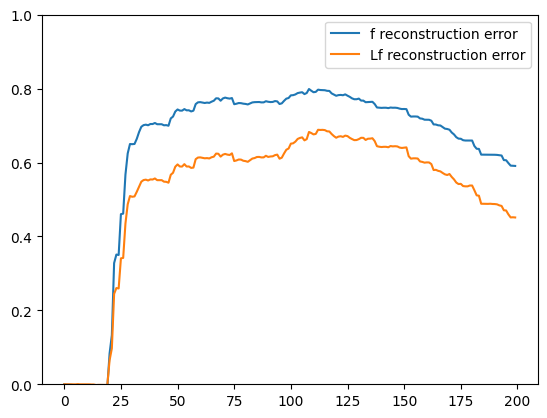

In [16]:
plt.plot(errs, label = 'f reconstruction error')
plt.plot(L_errs, label = 'Lf reconstruction error')

plt.ylim(0,1)
plt.legend()

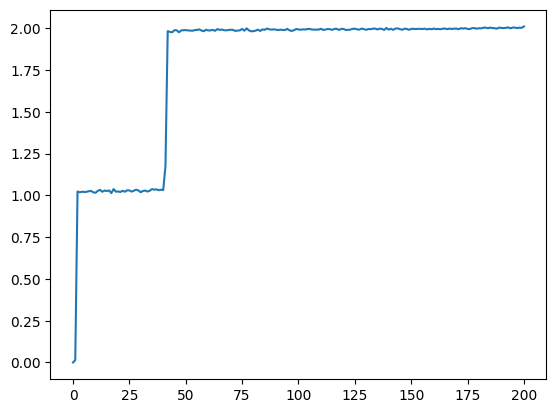

In [347]:
plt.plot(solver.fitted_eigvals, label = 'eigvals')

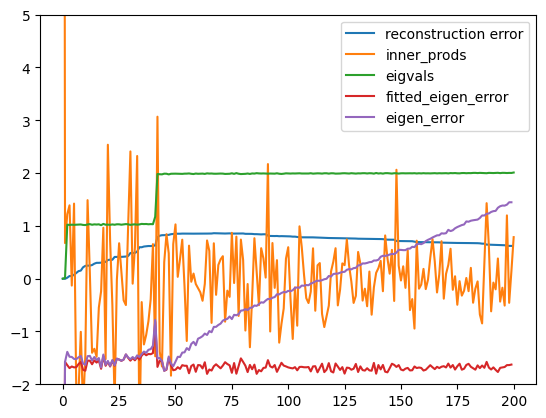

In [348]:
plt.plot(errs, label = 'reconstruction error')
plt.plot(inner_prods, label = 'inner_prods')
plt.plot(solver.fitted_eigvals, label = 'eigvals')
plt.plot(np.log10(out['fitted_eigen_error']),label = 'fitted_eigen_error')
plt.plot(np.log10(out['eigen_error']),label = 'eigen_error')

plt.ylim(-2,5)
plt.legend()

In [149]:
np.mean((func(x) - inner_prods@eigfuncs.T)**2)

np.float64(0.4760264414619271)

In [150]:
np.mean((func(x) - np.mean(func(x)))**2)

np.float64(1.219519479477328)

In [151]:
1-np.mean((func(x) - inner_prods@eigfuncs.T)**2)/np.mean((func(x) - np.mean(func(x)))**2)

np.float64(0.6096606495650676)

### Hyperparameter experiment

In [ ]:

for kernel_scale in tqdm(kernel_scales):
    for p in ps:
        #x, solver = polynomial_kernel_experiment(dim, p, kernel_scale, kernel_order=kernel_order)
        x, solver = gaussian_kernel_experiment(dim, p, kernel_scale)
        
        if solver is not None:
            eigen_errs.append(eigen_error(x,solver,k))
            orth_errs.append(orth_error(x,solver,k))
            L_prod_errs.append(L_prod_error(x,solver,k))
        else:
            eigen_errs.append(np.nan)
            orth_errs.append(np.nan)
            L_prod_errs.append(np.nan)

eigen_errs = np.array(eigen_errs).reshape((len(kernel_scales),len(ps)))
orth_errs = np.array(orth_errs).reshape((len(kernel_scales),len(ps)))
L_prod_errs = np.array(L_prod_errs).reshape((len(kernel_scales),len(ps)))

Text(0, 0.5, 'kernel scale')

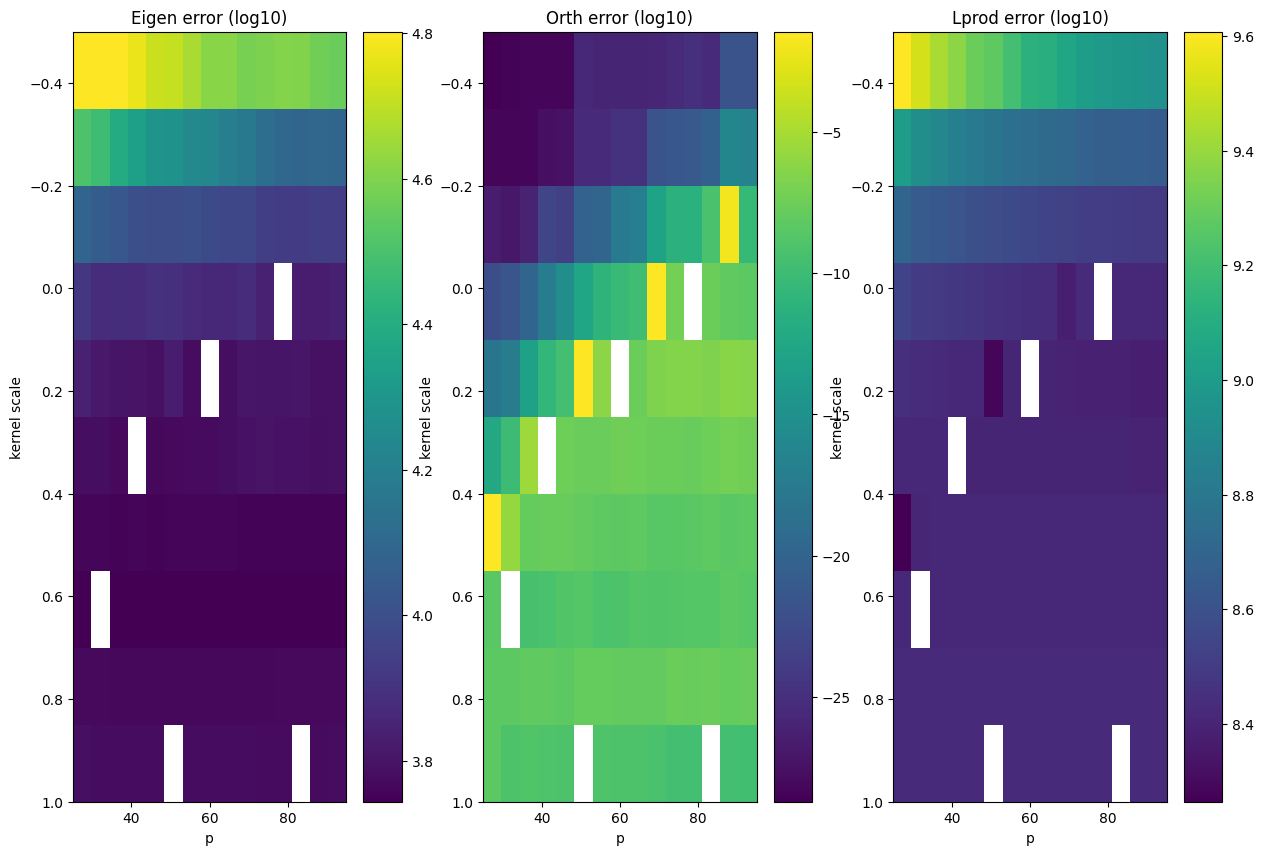

In [31]:
fig, ax = plt.subplots(1,3,figsize=(15,10))

cax = ax[0].imshow(np.log10(eigen_errs),extent=(ps[0],ps[-1],np.log10(kernel_scales[-1]),np.log10(kernel_scales[0])),aspect='auto')
cbar = fig.colorbar(cax, ax=ax[0],shrink=1)
ax[0].set_title('Eigen error (log10)')

cax = ax[1].imshow(np.log10(orth_errs),extent=(ps[0],ps[-1],np.log10(kernel_scales[-1]),np.log10(kernel_scales[0])),aspect='auto')
cbar = fig.colorbar(cax, ax=ax[1],shrink=1)
ax[1].set_title('Orth error (log10)')

cax = ax[2].imshow(np.log10(L_prod_errs),extent=(ps[0],ps[-1],np.log10(kernel_scales[-1]),np.log10(kernel_scales[0])),aspect='auto')
cbar = fig.colorbar(cax, ax=ax[2],shrink=1)
ax[2].set_title('Lprod error (log10)')

ax[0].set_xlabel('p')
ax[0].set_ylabel('kernel scale')
ax[1].set_xlabel('p')
ax[1].set_ylabel('kernel scale')
ax[2].set_xlabel('p')
ax[2].set_ylabel('kernel scale')

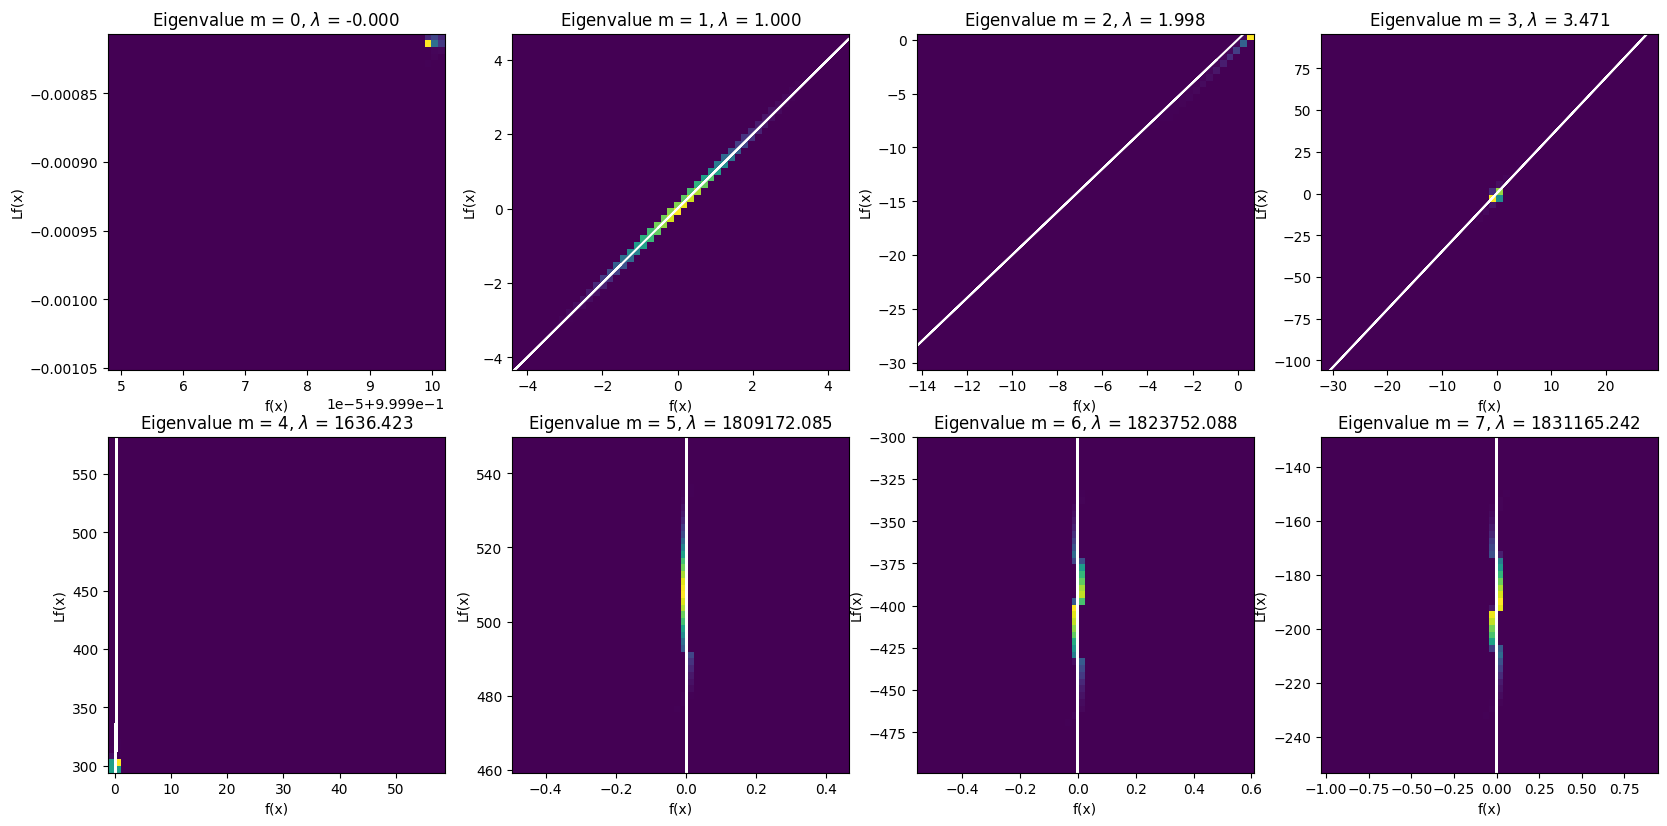

In [64]:
plot_eigenfunctions(x,solver,8)

In [12]:
grad = np.random.standard_normal((1000,100,10))

In [8]:
from itertools import product
import numpy as np

arrays = [np.array([1, 2]), np.array([3, 4]), [5]]
cartesian_product = np.array(list(product(*arrays)))

In [1]:
a = {'b': 1}
c = {'d': 4}

In [8]:
import numpy as np

In [9]:
class TestClass():
    def __init__(self, rng):
        self.rng = np.random.default_rng(rng)

    def random_number(self):
        print(self.rng.random(1))

In [16]:
rng = np.random.default_rng(32)

In [12]:
means = np.array([[0,0],[1,0]])
covs = np.array([np.eye(2),np.eye(2)])
w = np.array([0.5,0.5])

energy = GaussianMixture(w,means,covs)

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

In [7]:
sample = np.random.multivariate_normal(np.zeros(2), A, size = 10)
        

In [8]:
sample

array([[-1.03591711e+00, -4.38469364e-01],
       [-1.20226348e+00, -5.02518805e-01],
       [-5.90221913e-01, -6.32865982e-01],
       [-1.03081200e-01, -8.50193181e-01],
       [-1.50020486e-01, -3.26154397e-04],
       [ 2.65191361e-01,  9.31788362e-02],
       [ 9.81780193e-01,  2.54230429e-01],
       [ 1.67686907e+00,  3.78149627e-02],
       [-6.33384107e-01, -4.11349989e-01],
       [-1.98442068e-02, -2.65256227e-01]])